# 1, Read Data from SnowFlake
## 1.1 AOS data

In [4]:
!pip install -U sentence-transformers

In [5]:
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import numpy as np
import math
import pandas as pd
import re
from datetime import date, datetime
import sys
## Limit Size of Returned Records
MAX_QUERY_RETURN_SIZE = 1000000

## Credentials
SF_CREDS = 'hbo-max-content-datascience-snowflake-dev'

In [6]:
import json
import snowflake.connector
from abc import ABCMeta, abstractmethod
import boto3

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
        

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
def execute_query( query: str):
    input_dbname="MAX_DEV"
    input_schema = "WORKSPACE"
    connector = SnowflakeConnector(SSMPSCredentials(SF_CREDS))
    ctx = connector.connect(dbname=input_dbname, schema=input_schema)
    cur = ctx.cursor()
    try:
        cur.execute(query)
        results = cur.fetchmany()
        return results
    finally:
        cur.close()

# 1. Load Data

In [7]:
title_info_sql='''
create or replace table max_dev.content_datascience.joe_title_info_max as (
with base as (
select 
    *,
    coalesce(viewable_id,series_id) as consolidted_id
from 
(
select 
    series_id,
    PROGRAM_ID as viewable_id,
    asset_summary_long as title_plot,
    series_title_long as asset_title,
    content_category,
    age_group as asset_tags_age,
    program_type,
    primary_genre as primary_genre_desc,
    release_year,
    imdb_id 
from int_dai_prod_share.content_metadata_gold.asset_dim
) ckg
left join 
(select distinct title_id,imdb_rating,imdb_rating as WIKI_PAGE_VIEWS from max_prod.ckg.imdb_title) sd
on ckg.imdb_id=sd.title_id
)
select 
    consolidted_id,
    any_value(title_plot) as title_plot,
    any_value(asset_title) as asset_title,
    any_value(content_category) as content_category,
    any_value(ASSET_TAGS_AGE) as ASSET_TAGS_AGE,
    any_value(PROGRAM_TYPE) as PROGRAM_TYPE,
    any_value(PRIMARY_GENRE_DESC) as PRIMARY_GENRE_DESC,
    any_value(RELEASE_YEAR) as RELEASE_YEAR,
    avg(IMDB_RATING) as IMDB_RATING,
    avg(WIKI_PAGE_VIEWS) as WIKI_PAGE_VIEWS
from base 
group by consolidted_id 
);
'''
execute_query(title_info_sql)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


[('Table JOE_TITLE_INFO_MAX successfully created.',)]

In [8]:
title_info='''
select * from max_dev.content_datascience.joe_title_info_max
'''
input_dbname="MAX_DEV"
input_schema = "WORKSPACE"
connector = SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx = connector.connect(dbname=input_dbname, schema=input_schema)
title_info_db=pd.read_sql(title_info,ctx)
title_info_db.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


,CONSOLIDTED_ID,TITLE_PLOT,ASSET_TITLE,CONTENT_CATEGORY,ASSET_TAGS_AGE,PROGRAM_TYPE,PRIMARY_GENRE_DESC,RELEASE_YEAR,IMDB_RATING,WIKI_PAGE_VIEWS
0,9984c53a-641d-49e4-ae0e-bbac4e3277b3,"Trapped among an army of Weeping Angels, can t...",Doctor Who,episode,"[\n ""Family Content"",\n ""Young Adults""\n]",Acquired,Fantasy & Sci-Fi,2010.0,8.5,8.5
1,5bd33c9d-2ab7-4204-97ab-51bcac4c290a,Geneva's boyfriend wants to marry her--until M...,Hangin' with Mr. Cooper,episode,"[\n ""Pre-teens"",\n ""Family Content"",\n ""You...",Acquired,Comedy,1997.0,6.4,6.4
2,59e5127c-5533-4ae5-a407-defd7df94dad,Tyrion roots out a spy. Catelyn meets a new ki...,Game of Thrones,episode,[],Original,Drama,2012.0,8.7,8.7
3,8f3e0583-84c5-48e3-be0b-66deb8497583,After surviving and escaping an abusive marria...,A Vigilante,movie,[],Acquired,Drama,2019.0,5.7,5.7
4,4a6b90d9-f3ab-4f80-9a0a-baaf4a45e7db,Selçuk confronts Volkan. Bahar checks on Mert ...,A Woman Scorned,episode,[],Acquired,Novela,2020.0,6.4,6.4


In [9]:
# aosstr_prep='''
# create or replace table max_dev.content_datascience.joe_title_aos_max as ( 
# select distinct a.consolidated_id_1,a.consolidated_title_1, a.consolidated_id_2,a.consolidated_title_2,greatest(a.score,b.score) as score,a.level_1_catg_name_1,a.level_1_catg_name_2 from MAX_prod.content_Datascience.AOS_ALL_US_PROD a 
# left join MAX_prod.content_Datascience.AOS_ALL_US_PROD b
# on a.consolidated_id_1=b.consolidated_id_2 and a.consolidated_id_2=b.consolidated_id_1);
# '''

# execute_query(aosstr_prep)

In [10]:
aosstr='''
with base as (
 select *, row_number() over (partition by CONSOLIDATED_TITLE_1 order by SCORE desc) as r 
 from max_dev.content_datascience.joe_title_aos_max )
select * from base where r<=100;
'''
aos_db=pd.read_sql(aosstr,ctx)
aos_db.head()

,CONSOLIDATED_ID_1,CONSOLIDATED_TITLE_1,CONSOLIDATED_ID_2,CONSOLIDATED_TITLE_2,SCORE,LEVEL_1_CATG_NAME_1,LEVEL_1_CATG_NAME_2,R
0,8fa4908b-10d0-473e-b11c-cafb0921f6dc,90 day fiance: b90 strikes back!,8fa4908b-10d0-473e-b11c-cafb0921f6dc,90 day fiance: b90 strikes back!,1.000000,series,series,1
1,8fa4908b-10d0-473e-b11c-cafb0921f6dc,90 day fiance: b90 strikes back!,6e04063b-47b7-4c44-92cf-d4354406c565,90 day: the last resort,1.000000,series,series,2
2,8fa4908b-10d0-473e-b11c-cafb0921f6dc,90 day fiance: b90 strikes back!,f00f5486-4bf3-461f-8272-a5598cc7865d,90 day fiance,0.999144,series,series,3
3,8fa4908b-10d0-473e-b11c-cafb0921f6dc,90 day fiance: b90 strikes back!,b5598713-bb7d-4dca-b797-fa3ca2f31f42,90 day: the single life,0.993989,series,series,4
4,8fa4908b-10d0-473e-b11c-cafb0921f6dc,90 day fiance: b90 strikes back!,0d9842b3-6ffa-45b7-9ead-21d01e32823f,street outlaws vs. the world,0.986205,series,series,5


# 2. Encode data

In [ ]:
!jupyter labextension install jupyter-matplotlib@0.3.0

In [11]:
from sentence_transformers import SentenceTransformer
encode_model = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [14]:
title_info_db['TITLE_PLOT']=title_info_db['TITLE_PLOT'].fillna('')

In [16]:
title_info_db['tile_embedding']=encode_model.encode(title_info_db['TITLE_PLOT'].values).tolist()
title_info_db.head()

,CONSOLIDTED_ID,TITLE_PLOT,ASSET_TITLE,CONTENT_CATEGORY,ASSET_TAGS_AGE,PROGRAM_TYPE,PRIMARY_GENRE_DESC,RELEASE_YEAR,IMDB_RATING,WIKI_PAGE_VIEWS,tile_embedding
0,9984c53a-641d-49e4-ae0e-bbac4e3277b3,"Trapped among an army of Weeping Angels, can t...",Doctor Who,episode,"[\n ""Family Content"",\n ""Young Adults""\n]",Acquired,Fantasy & Sci-Fi,2010.0,8.5,8.5,"[0.022789673879742622, 0.0890822634100914, 0.0..."
1,5bd33c9d-2ab7-4204-97ab-51bcac4c290a,Geneva's boyfriend wants to marry her--until M...,Hangin' with Mr. Cooper,episode,"[\n ""Pre-teens"",\n ""Family Content"",\n ""You...",Acquired,Comedy,1997.0,6.4,6.4,"[-0.06971671432256699, 0.059893134981393814, 0..."
2,59e5127c-5533-4ae5-a407-defd7df94dad,Tyrion roots out a spy. Catelyn meets a new ki...,Game of Thrones,episode,[],Original,Drama,2012.0,8.7,8.7,"[0.015201307833194733, -0.016968216747045517, ..."
3,8f3e0583-84c5-48e3-be0b-66deb8497583,After surviving and escaping an abusive marria...,A Vigilante,movie,[],Acquired,Drama,2019.0,5.7,5.7,"[-0.002238643355667591, -0.09934654831886292, ..."
4,4a6b90d9-f3ab-4f80-9a0a-baaf4a45e7db,Selçuk confronts Volkan. Bahar checks on Mert ...,A Woman Scorned,episode,[],Acquired,Novela,2020.0,6.4,6.4,"[-0.02949143946170807, 0.08987138420343399, -0..."


In [18]:
title_info_db.columns.values

array(['CONSOLIDTED_ID', 'TITLE_PLOT', 'ASSET_TITLE', 'CONTENT_CATEGORY',
       'ASSET_TAGS_AGE', 'PROGRAM_TYPE', 'PRIMARY_GENRE_DESC',
       'RELEASE_YEAR', 'IMDB_RATING', 'WIKI_PAGE_VIEWS', 'tile_embedding'],
      dtype=object)

In [19]:
aos_embedding_db=aos_db.merge(title_info_db,left_on='CONSOLIDATED_ID_1',right_on='CONSOLIDTED_ID')
aos_embedding_db.head()

,CONSOLIDATED_ID_1,CONSOLIDATED_TITLE_1,CONSOLIDATED_ID_2,CONSOLIDATED_TITLE_2,SCORE,LEVEL_1_CATG_NAME_1,LEVEL_1_CATG_NAME_2,R,CONSOLIDTED_ID,TITLE_PLOT,ASSET_TITLE,CONTENT_CATEGORY,ASSET_TAGS_AGE,PROGRAM_TYPE,PRIMARY_GENRE_DESC,RELEASE_YEAR,IMDB_RATING,WIKI_PAGE_VIEWS,tile_embedding
0,6329cae0-837b-40fc-8a0f-821ec42a72a3,because of winn-dixie,6329cae0-837b-40fc-8a0f-821ec42a72a3,because of winn-dixie,1.000000,movies,movies,1,6329cae0-837b-40fc-8a0f-821ec42a72a3,A lonely little girl bonds with a friendly str...,Because of Winn-Dixie,movie,"[\n ""Pre-teens"",\n ""Family Content"",\n ""You...",Acquired,Kids & Family,2005.0,6.4,6.4,"[0.005083524156361818, -0.03101217746734619, 0..."
1,6329cae0-837b-40fc-8a0f-821ec42a72a3,because of winn-dixie,00bcd5bf-6b63-40a2-a78e-d46e2f3d111c,cold case,1.000000,movies,series,2,6329cae0-837b-40fc-8a0f-821ec42a72a3,A lonely little girl bonds with a friendly str...,Because of Winn-Dixie,movie,"[\n ""Pre-teens"",\n ""Family Content"",\n ""You...",Acquired,Kids & Family,2005.0,6.4,6.4,"[0.005083524156361818, -0.03101217746734619, 0..."
2,6329cae0-837b-40fc-8a0f-821ec42a72a3,because of winn-dixie,447e451d-ef9c-4100-8474-a5fa2d9af3e5,agent cody banks,0.999091,movies,movies,3,6329cae0-837b-40fc-8a0f-821ec42a72a3,A lonely little girl bonds with a friendly str...,Because of Winn-Dixie,movie,"[\n ""Pre-teens"",\n ""Family Content"",\n ""You...",Acquired,Kids & Family,2005.0,6.4,6.4,"[0.005083524156361818, -0.03101217746734619, 0..."
3,6329cae0-837b-40fc-8a0f-821ec42a72a3,because of winn-dixie,f0feafed-320a-4463-8a43-f18d11e769e6,the fluffy movie,0.998681,movies,movies,4,6329cae0-837b-40fc-8a0f-821ec42a72a3,A lonely little girl bonds with a friendly str...,Because of Winn-Dixie,movie,"[\n ""Pre-teens"",\n ""Family Content"",\n ""You...",Acquired,Kids & Family,2005.0,6.4,6.4,"[0.005083524156361818, -0.03101217746734619, 0..."
4,6329cae0-837b-40fc-8a0f-821ec42a72a3,because of winn-dixie,34a2bec6-d564-4fab-8957-55d967e156d4,step by step,0.998261,movies,series,5,6329cae0-837b-40fc-8a0f-821ec42a72a3,A lonely little girl bonds with a friendly str...,Because of Winn-Dixie,movie,"[\n ""Pre-teens"",\n ""Family Content"",\n ""You...",Acquired,Kids & Family,2005.0,6.4,6.4,"[0.005083524156361818, -0.03101217746734619, 0..."


In [16]:
aos_embedding_db=aos_embedding_db.rename({'tile_embedding':'tile_embedding_1'},axis=1)
aos_embedding_db.drop('CONSOLIDTED_ID',axis=1,inplace=True)
aos_embedding_db.head()

,CONSOLIDATED_ID_1,CONSOLIDATED_TITLE_1,CONSOLIDATED_ID_2,CONSOLIDATED_TITLE_2,SCORE,LEVEL_1_CATG_NAME_1,LEVEL_1_CATG_NAME_2,R,TITLE_PLOT,ASSET_TITLE,CONTENT_CATEGORY,ASSET_TAGS_AGE,PROGRAM_TYPE,PRIMARY_GENRE_DESC,RELEASE_YEAR,IMDB_RATING,WIKI_PAGE_VIEWS,tile_embedding_1
0,6329cae0-837b-40fc-8a0f-821ec42a72a3,because of winn-dixie,6329cae0-837b-40fc-8a0f-821ec42a72a3,because of winn-dixie,1.000000,movies,movies,1,A lonely little girl bonds with a friendly str...,Because of Winn-Dixie,movie,"[\n ""Pre-teens"",\n ""Family Content"",\n ""You...",Acquired,Kids & Family,2005.0,6.3,6.3,"[0.005083524156361818, -0.03101217746734619, 0..."
1,6329cae0-837b-40fc-8a0f-821ec42a72a3,because of winn-dixie,f0feafed-320a-4463-8a43-f18d11e769e6,the fluffy movie,1.000000,movies,movies,2,A lonely little girl bonds with a friendly str...,Because of Winn-Dixie,movie,"[\n ""Pre-teens"",\n ""Family Content"",\n ""You...",Acquired,Kids & Family,2005.0,6.3,6.3,"[0.005083524156361818, -0.03101217746734619, 0..."
2,6329cae0-837b-40fc-8a0f-821ec42a72a3,because of winn-dixie,5343c82a-de51-4a09-8321-a2cc7200afe2,lucas the spider shorts: meet the boop troop,0.999878,movies,series,3,A lonely little girl bonds with a friendly str...,Because of Winn-Dixie,movie,"[\n ""Pre-teens"",\n ""Family Content"",\n ""You...",Acquired,Kids & Family,2005.0,6.3,6.3,"[0.005083524156361818, -0.03101217746734619, 0..."
3,6329cae0-837b-40fc-8a0f-821ec42a72a3,because of winn-dixie,34a2bec6-d564-4fab-8957-55d967e156d4,step by step,0.999278,movies,series,4,A lonely little girl bonds with a friendly str...,Because of Winn-Dixie,movie,"[\n ""Pre-teens"",\n ""Family Content"",\n ""You...",Acquired,Kids & Family,2005.0,6.3,6.3,"[0.005083524156361818, -0.03101217746734619, 0..."
4,6329cae0-837b-40fc-8a0f-821ec42a72a3,because of winn-dixie,8f26265f-eb95-44b3-aff9-499af9fa519d,elizabethtown,0.999086,movies,movies,5,A lonely little girl bonds with a friendly str...,Because of Winn-Dixie,movie,"[\n ""Pre-teens"",\n ""Family Content"",\n ""You...",Acquired,Kids & Family,2005.0,6.3,6.3,"[0.005083524156361818, -0.03101217746734619, 0..."


In [17]:
aos_embedding_db=aos_embedding_db.merge(title_info_db[['CONSOLIDTED_ID','tile_embedding']],left_on='CONSOLIDATED_ID_2',right_on='CONSOLIDTED_ID')
aos_embedding_db=aos_embedding_db.rename({'tile_embedding':'tile_embedding_2'},axis=1)
aos_embedding_db.drop('CONSOLIDTED_ID',axis=1,inplace=True)
aos_embedding_db.head()

NameError: name 'aos_embedding_db' is not defined

# 3 Models

In [18]:
from keras.layers import Input, Embedding, Dot, Reshape, Dense, Average,Flatten
from keras.models import Model
import keras as keras
import tensorflow as tf

In [19]:
index_df=aos_embedding_db[['CONSOLIDATED_TITLE_1','CONSOLIDATED_ID_1','TITLE_PLOT']].drop_duplicates(['CONSOLIDATED_ID_1']).reset_index(drop=True)
index_df=index_df.reset_index()
index_df_short=index_df[['index','CONSOLIDATED_ID_1']]

In [20]:
X=aos_embedding_db[['CONSOLIDATED_ID_1','CONSOLIDATED_ID_2','SCORE']].merge(index_df_short,left_on='CONSOLIDATED_ID_1',right_on='CONSOLIDATED_ID_1')[['index','CONSOLIDATED_ID_2','SCORE']]
X=X.merge(index_df_short,left_on='CONSOLIDATED_ID_2',right_on='CONSOLIDATED_ID_1')[['index_x','index_y','SCORE']]
X.head()

,index_x,index_y,SCORE
0,0,0,1.000000
1,1,0,0.966250
2,2,0,0.966781
3,3,0,0.963654
4,4,0,0.968497


In [21]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X[['index_x','index_y']].values, X['SCORE'].values, test_size=0.30, shuffle= True,random_state = 1)

In [22]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional,GlobalMaxPooling1D,GlobalAveragePooling1D,GlobalAveragePooling2D,InputLayer
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.callbacks import *
from sentence_transformers import SentenceTransformer
from keras.utils.vis_utils import plot_model

In [23]:
encode_model = SentenceTransformer('all-MiniLM-L6-v2')
embedding_matrix=encode_model.encode(index_df['TITLE_PLOT'].values)
embedding_matrix

array([[ 0.00508352, -0.03101218,  0.02634954, ..., -0.00178513,
         0.01965805,  0.03473888],
       [-0.04721878, -0.00791544, -0.12020949, ..., -0.04834492,
         0.0538466 , -0.05788429],
       [-0.09532683, -0.0746844 , -0.00241762, ...,  0.05926197,
         0.06412265, -0.05657747],
       ...,
       [-0.08033396,  0.07317606,  0.05523913, ...,  0.01539903,
         0.03414191,  0.08773005],
       [ 0.01560387,  0.05884964,  0.04542042, ..., -0.02970629,
         0.02437774, -0.04470088],
       [-0.06407025,  0.00679792, -0.06227691, ...,  0.00608141,
        -0.00716116,  0.00920511]], dtype=float32)

In [24]:
model=Sequential()
model.add(Embedding(index_df.shape[0],384,weights=[embedding_matrix],input_length=2,trainable=True))

#model.add(LSTM(128,return_sequences=True,dropout=0.2))
model.add(LSTM(128,return_sequences=True))
model.add(GlobalAveragePooling1D())

model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,loss='mean_absolute_error',metrics=['accuracy','mae','mse'])

es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)
mc=ModelCheckpoint('best_model.h5',monitor='val_acc',model='max',save_best_only=True, verbose=1)

print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2, 384)            1304832   
_________________________________________________________________
lstm (LSTM)                  (None, 2, 128)            262656    
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,575,809
Trainable params: 1,575,809
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2, 384)            1304832   
_________________________________________________________________
lstm (LSTM)                  (None, 2, 128)            262656    
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,575,809
Trainable params: 1,575,809
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
history=model.fit(x_train,y_train,batch_size=128,epochs=8,validation_data=(x_val,y_val),verbose=1,
                  callbacks=[es,mc]
                 )


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/8
1160/1160 [==============================] - 12s 8ms/step - loss: 0.0238 - accuracy: 0.0160 - mae: 0.0238 - mse: 0.0031 - val_loss: 0.0139 - val_accuracy: 0.0160 - val_mae: 0.0139 - val_mse: 3.9950e-04
Epoch 2/8
1160/1160 [==============================] - 9s 8ms/step - loss: 0.0127 - accuracy: 0.0160 - mae: 0.0127 - mse: 3.2303e-04 - val_loss: 0.0122 - val_accuracy: 0.0160 - val_mae: 0.0122 - val_mse: 3.0220e-04
Epoch 3/8
1160/1160 [==============================] - 9s 8ms/step - loss: 0.0117 - accuracy: 0.0160 - mae: 0.0117 - mse: 2.8142e-04 - val_loss: 0.0124 - val_accuracy: 0.0160 - val_mae: 0.0124 - val_mse: 2.9854e-04
Epoch 4/8
1160/1160 [==============================] - 9s 8ms/step - loss: 0.0112 - accuracy: 0.0160 - mae: 0.0112 - mse: 2.6476e-04 - val_loss: 0.0114 - val_accuracy: 0.0160 - val_mae: 0.0114 - val_mse: 2.8191e-04
Epoch

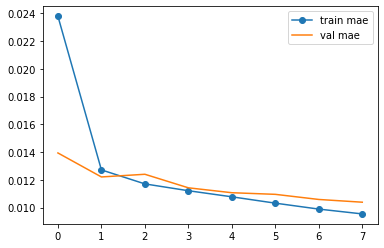

In [27]:
#plt.ylim((0.04, 0.08))
plt.plot(history.history['mae'], '-o', label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.legend()

# 4. Output Embeddings

In [29]:
def extract_weights(name, model):
    """Extract weights from a neural network model"""
    
    # Extract weights
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    
    # Normalize
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

title_weights = extract_weights('embedding', model)

title_weights

array([[-0.05698793, -0.00945184,  0.00824753, ...,  0.01035481,
         0.03070122, -0.01702808],
       [-0.0607155 ,  0.02825691, -0.11061092, ..., -0.09670626,
         0.06508785, -0.07246641],
       [-0.08773243, -0.03527224, -0.05035307, ...,  0.08560173,
         0.07643592, -0.05277606],
       ...,
       [-0.08652083,  0.06800186,  0.05550158, ...,  0.09967499,
         0.01907788,  0.08861474],
       [-0.01794074,  0.08050019,  0.04566917, ...,  0.03164522,
         0.0469062 , -0.01085061],
       [-0.06736868,  0.06026992,  0.00315971, ..., -0.02205714,
        -0.01914579,  0.02860425]], dtype=float32)